In [11]:
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

In [ ]:
def parse_yaml_for_optimistic_r(file_path: Path):
    """
    Parse a YAML file to extract optimistic r values and their corresponding number_t1 and number_t2.

    Args:
        file_path (Path): Path to the YAML file.

    Returns:
        dict: A dictionary with r values as keys and (number_t1, number_t2) as values.
    """
    # Read the YAML file
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)

    results = {}

    for solution in data.get("optimistic", {}).get("all_solutions", []):
        r_value = solution.get("r")
        fleet_data = solution.get("assignment", {}).get("sub", {}).get("dp_fleet", {}).get("functionality", {})
        number_t1 = int(fleet_data.get("amount_fleet_1", 0))
        number_t2 = int(fleet_data.get("amount_fleet_2", 0))
        results[r_value] = (number_t1, number_t2)

    return results

In [13]:
units = {"Cost":"(USD)", "Dissatisfaction":"", "Emission":"(kg/a)"}

In [14]:
def process_string(input_str):
    trimmed = input_str.strip()
    if trimmed.startswith('⟨'):
        trimmed = trimmed[1:]  # remove the leading '⟨'

    # Now split by '⟩, ⟨' to break into segments
    segments = trimmed.split('⟩,\n ⟨')

    # The last segment will still have a trailing '⟩' at the end. Remove it.
    if segments:
        segments[-1] = segments[-1].replace('⟩', '')

    result = []
    for seg in segments:
        parts = seg.split(',')
        # parts example: ['2052000 USD', '303', '2000 kg/a']

        usd_str = parts[0].strip().replace(' USD', '')
        usd_val = eval(usd_str)
        
        val2 = eval(parts[1].strip())
        
        kg_str = parts[2].strip().replace(' kg/a', '')
        kg_val = eval(kg_str)
        
        kg_val = kg_val
        
        result.append((usd_val, val2, kg_val))

    return result

In [15]:
def parse_results(output_dir, mode='pessimistic',extract_base=True):
    
    # Parse the results
    cost_list = []
    dissatisfaction_list = []
    emission_list = []
        
    with open(f"{output_dir}/output.yaml", 'r', encoding="UTF-8") as f:
        data = yaml.safe_load(f)
        data_all = process_string(data[mode]['pretty'][2:-1])

    # Put the results in NumPy arrays
    for each in data_all:
        cost_list.append(each[0])
        dissatisfaction_list.append(each[1])
        emission_list.append(each[2])
    
    if extract_base:
        base = min(dissatisfaction_list)
        dissatisfaction_list = [each-base for each in dissatisfaction_list]

    # Store the results in a dictionary
    results = {
        'Cost': cost_list,
        'Dissatisfaction': dissatisfaction_list,
        'Emission': emission_list,
    }

    return results

In [16]:
def get_antichain(output, resource1='Cost', resource2='Emission'):
    r1 = output[resource1]
    r2 = output[resource2]

    pairs = list(zip(r1, r2))
    pairs.sort()

    antichain = []
    for p in pairs:
        if all(not ( (p[0] <= q[0] and p[1] <= q[1]) or (q[0] <= p[0] and q[1] <= p[1]) )
            for q in antichain):
            antichain.append(p)
    
    return antichain

In [17]:
def plot_pareto(output_path, resource1="Cost", resource2="Emission"):
    """Plot pareto front of resource 1 and resource 2. Pick resource among (Cost, Dissatisfaction, Emission).

    output_path: output root directory
    """
    
    output = parse_results(output_path)
    antichain = get_antichain(output, resource1, resource2)

    plot_x = []
    plot_y = []
    for i,(x,y) in enumerate(antichain):
        plot_x.append(x)
        plot_y.append(y)
        if i < len(antichain)-1:
            x_next,y_next = antichain[i+1]
            x_inter = min(x,x_next)
            y_inter = min(y,y_next)
            plot_x.append(x_inter)
            plot_y.append(y_inter)
    print('\n'.join([f'{x}, {y}' for x,y in zip(plot_x, plot_y)]))
    plt.plot(plot_x,plot_y, color='teal', linewidth=2)
    plt.scatter(plot_x[1::2],plot_y[1::2], s=50, color='teal')
    plt.fill_between(plot_x,y1=plot_y,y2=max(plot_y), color='teal', alpha=0.1)
    plt.xlabel(resource1 + units[resource1], fontsize=14, fontweight='bold')
    plt.ylabel(resource2 + units[resource2], fontsize=14, fontweight='bold')
    plt.title(f"Pareto Front {resource1} - {resource2}", fontsize=18, fontweight='bold', pad=20)


In [19]:
file_path = Path("bus.mcdplib/out-solve-query/output.yaml")
parsed_results = parse_yaml_for_optimistic_r(file_path)
print(parsed_results)

{}


In [10]:
plot_pareto("out-query","Cost","Dissatisfaction")
plt.xlim(1_500_000)
# plt.title('Pareto Front Cost - Satisfaction', fontsize=18, fontweight='bold', pad=20)
# plt.ylabel('Satisfaction Level')

FileNotFoundError: [Errno 2] No such file or directory: 'out-query/output.yaml'

0.0, 1440
0.0, 1200
0.040666666999982226, 1200
0.040666666999982226, 960
0.1016666670000177, 960
0.1016666670000177, 720
0.20333333399997855, 720
0.20333333399997855, 480
0.4066666670000245, 480


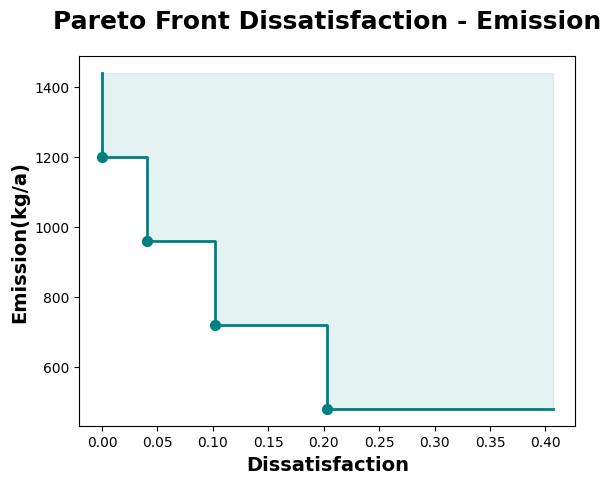

In [ ]:
plot_pareto("out-query","Dissatisfaction","Emission")
# plt.title('Pareto Front Di - Emission', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Satisfaction Level')